# Strategy 1: EMA Crossover

2025-03-22 15:04:26.586030: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/3019903940.py:182: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc['2024-01-17':'2025-01-16']


Grid Search Results (Two EMA):
Short EMA = 5, Long EMA = 30 --> Total Return: 10.54%
Short EMA = 5, Long EMA = 31 --> Total Return: 14.51%
Short EMA = 5, Long EMA = 32 --> Total Return: 23.11%
Short EMA = 5, Long EMA = 33 --> Total Return: 25.17%
Short EMA = 5, Long EMA = 34 --> Total Return: 12.75%
Short EMA = 5, Long EMA = 35 --> Total Return: 12.75%
Short EMA = 5, Long EMA = 36 --> Total Return: 21.55%
Short EMA = 5, Long EMA = 37 --> Total Return: 22.05%
Short EMA = 5, Long EMA = 38 --> Total Return: 22.05%
Short EMA = 5, Long EMA = 39 --> Total Return: 22.05%
Short EMA = 5, Long EMA = 40 --> Total Return: 14.95%
Short EMA = 5, Long EMA = 41 --> Total Return: 14.95%
Short EMA = 5, Long EMA = 42 --> Total Return: 22.85%
Short EMA = 5, Long EMA = 43 --> Total Return: 23.27%
Short EMA = 5, Long EMA = 44 --> Total Return: 20.36%
Short EMA = 5, Long EMA = 45 --> Total Return: 20.36%
Short EMA = 5, Long EMA = 46 --> Total Return: 18.16%
Short EMA = 5, Long EMA = 47 --> Total Return: 18.1

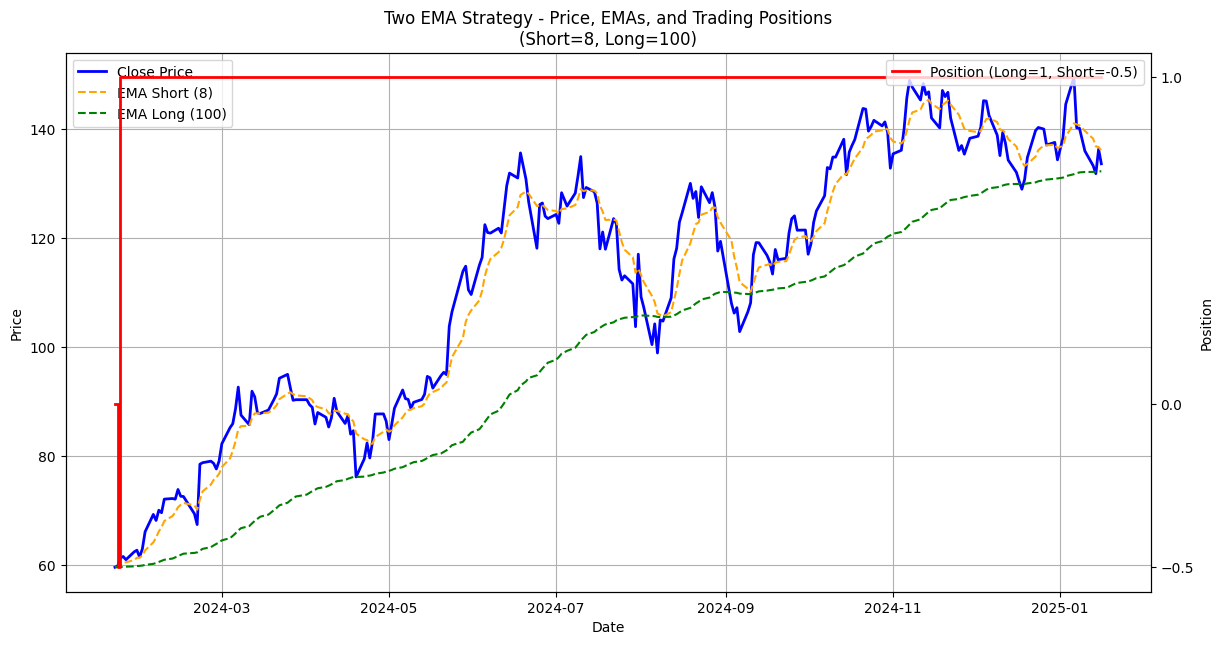

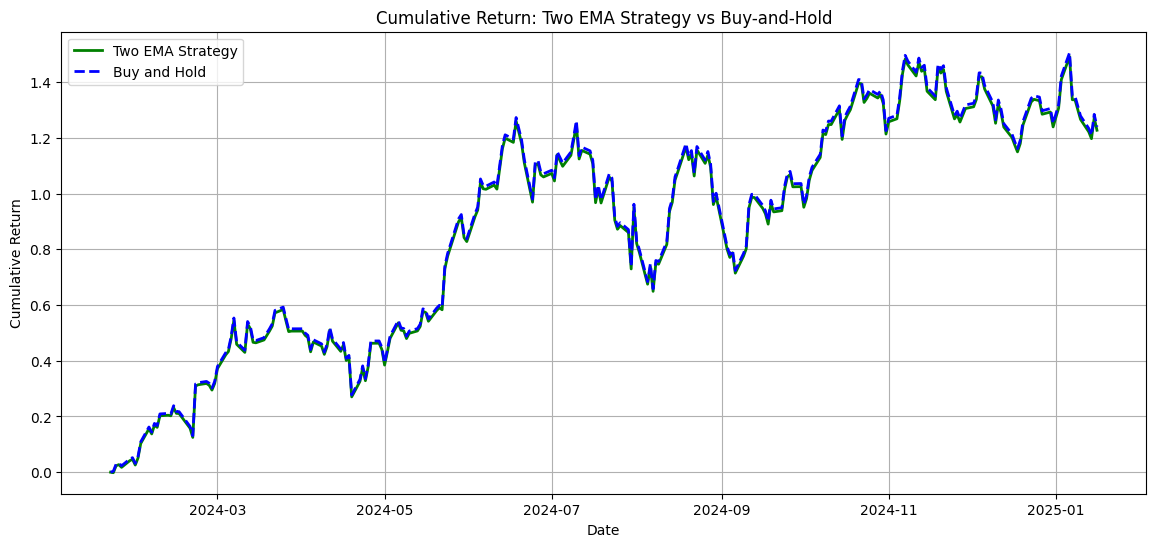


Trade List (Trade Open Date, Trade Close Date, Position, Entry Price, Exit Price, Trade Return):
  Trade Open Date Trade Close Date  Position  Entry Price  Exit Price  \
0      2024-01-22       2024-01-23       0.0    59.637096   59.856033   
1      2024-01-23       2024-01-24      -0.5    59.856033   61.344608   
2      2024-01-24       2025-01-16       1.0    61.344608  133.570007   

   Trade Return  
0      0.000000  
1     -0.024869  
2      1.177372  
Final Cumulative Return of Two EMA Strategy: 122.74%
Final Capital: $111,371.25
Buy & Hold Return: 123.97%


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random
import tensorflow as tf

# --- Two EMA Calculation ---
def calculate_two_ema(df, short_window, long_window):
    """
    Calculates two EMAs (short and long) from closing prices.
    """
    df = df.copy()
    df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    return df

# --- Two EMA Strategy Implementation ---
def two_ema_strategy(df, short_window, long_window):
    """
    Implements a two EMA crossover strategy.
    Trading signals:
      - If EMA_short > EMA_long: Long (1.0)
      - Else: Short (-0.5)
    Positions are shifted by one day to avoid lookahead bias.
    Daily returns are computed from the percentage change in the closing price,
    and cumulative returns are calculated.
    """
    df = calculate_two_ema(df, short_window, long_window)
    
    # Generate trading signal based on EMA crossover.
    df['Position'] = np.where(df['EMA_short'] > df['EMA_long'], 1.0, -0.5)
    # Shift positions by one day to avoid lookahead bias.
    df['Position'] = pd.Series(df['Position'], index=df.index).shift(1).fillna(0)
    
    # Calculate daily returns.
    df['Returns'] = df['Close'].pct_change().fillna(0)
    # Strategy returns based on the position.
    df['StrategyReturn'] = df['Position'] * df['Returns']
    df['CumulativeReturn'] = (1 + df['StrategyReturn']).cumprod() - 1
    
    # Also compute Buy & Hold cumulative return.
    df['BuyHoldReturn'] = (1 + df['Returns']).cumprod() - 1
    
    total_return = df['CumulativeReturn'].iloc[-1]
    return total_return, df

# --- Grid Search for Optimal Two EMA Parameters ---
def two_ema_grid_search(df, short_range, long_range):
    """
    Performs grid search over candidate short and long EMA periods.
    Only combinations with short < long are considered.
    Returns the best parameter set, the corresponding cumulative return,
    and a dictionary of results.
    """
    best_params = None
    best_return = -np.inf
    results = {}
    
    for short in short_range:
        for long in long_range:
            if short >= long:
                continue  # Ensure non-overlap.
            total_return, _ = two_ema_strategy(df.copy(), short, long)
            results[(short, long)] = total_return
            if total_return > best_return:
                best_return = total_return
                best_params = (short, long)
                
    return best_params, best_return, results

# --- Combined Plotting Function ---
def plot_two_ema_combined(df, best_params):
    """
    Plots a combined chart showing:
      - Actual stock price.
      - Short and Long EMAs.
      - Trading positions as a step plot.
      - Also displays the Buy & Hold cumulative return.
    """
    fig, ax1 = plt.subplots(figsize=(14, 7))
    
    # Plot actual price and EMA lines.
    ax1.plot(df.index, df['Close'], label='Close Price', color='blue', linewidth=2)
    ax1.plot(df.index, df['EMA_short'], label=f'EMA Short ({best_params[0]})', color='orange', linestyle='--', linewidth=1.5)
    ax1.plot(df.index, df['EMA_long'], label=f'EMA Long ({best_params[1]})', color='green', linestyle='--', linewidth=1.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')
    ax1.grid(True)
    
    # Create a secondary y-axis for trading positions.
    ax2 = ax1.twinx()
    ax2.step(df.index, df['Position'], where='post', label='Position (Long=1, Short=-0.5)', color='red', linewidth=2)
    ax2.set_ylabel('Position')
    ax2.set_yticks([-0.5, 0, 1])
    ax2.legend(loc='upper right')
    
    plt.title(f'Two EMA Strategy - Price, EMAs, and Trading Positions\n(Short={best_params[0]}, Long={best_params[1]})')
    plt.show()
    
    # Plot cumulative returns: Strategy vs. Buy & Hold.
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['CumulativeReturn'], label='Two EMA Strategy', color='green', linewidth=2)
    plt.plot(df.index, df['BuyHoldReturn'], label='Buy and Hold', color='blue', linestyle='--', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('Cumulative Return: Two EMA Strategy vs Buy-and-Hold')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- Get Trade List ---
def get_trade_list(df):
    """
    Returns a DataFrame summarizing each trade segment.
    For each trade, outputs:
      - Trade Open Date
      - Trade Close Date
      - Position (1 for long, -0.5 for short)
      - Entry Price (price at trade open)
      - Exit Price (price at trade close)
      - Trade Return (computed accordingly)
    """
    trade_dates = df.index[df['Position'].ne(df['Position'].shift(1))]
    trades = []
    for i in range(len(trade_dates) - 1):
        open_date = trade_dates[i]
        close_date = trade_dates[i + 1]
        entry_price = df.loc[open_date, 'Close']
        exit_price = df.loc[close_date, 'Close']
        position = df.loc[open_date, 'Position']
        if position > 0:
            trade_return = (exit_price - entry_price) / entry_price
        elif position < 0:
            trade_return = (entry_price - exit_price) / entry_price
        else:
            trade_return = 0.0
        trades.append({
            'Trade Open Date': open_date,
            'Trade Close Date': close_date,
            'Position': position,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Trade Return': trade_return
        })
    # For the final segment:
    if len(trade_dates) > 0:
        open_date = trade_dates[-1]
        entry_price = df.loc[open_date, 'Close']
        close_date = df.index[-1]
        exit_price = df.iloc[-1]['Close']
        position = df.loc[open_date, 'Position']
        if position > 0:
            trade_return = (exit_price - entry_price) / entry_price
        elif position < 0:
            trade_return = (entry_price - exit_price) / entry_price
        else:
            trade_return = 0.0
        trades.append({
            'Trade Open Date': open_date,
            'Trade Close Date': close_date,
            'Position': position,
            'Entry Price': entry_price,
            'Exit Price': exit_price,
            'Trade Return': trade_return
        })
    return pd.DataFrame(trades)

# --- Two EMA Crossover Strategy with Grid Search and Comparison ---
def two_ema_crossover_strategy(df, initial_capital=50000):
    """
    Uses a two EMA crossover strategy.
    It performs grid search over candidate short and long EMA periods (non-overlapping)
    and then applies the best parameters. It also plots a combined chart of price, EMA lines,
    and trading positions, and compares the cumulative return against a buy-and-hold benchmark.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    # Filter for period of interest.
    df = df.loc['2024-01-17':'2025-01-16']
    if df.empty:
        raise ValueError("Filtered data is empty. Check your CSV date range.")
    
    # Define candidate ranges (ensuring no overlap: short < long).
    short_range = range(5, 21)   # 5,6,...,20
    long_range  = range(30, 101)  # 30,31,...,100
    
    best_params, best_return, grid_results = two_ema_grid_search(df, short_range, long_range)
    print("Grid Search Results (Two EMA):")
    for params, ret in grid_results.items():
        print(f"Short EMA = {params[0]}, Long EMA = {params[1]} --> Total Return: {ret:.2%}")
    print(f"\nBest Two EMA parameters: Short = {best_params[0]}, Long = {best_params[1]} with Total Return: {best_return:.2%}")
    
    # Apply the best strategy.
    total_return_strategy, strategy_df = two_ema_strategy(df, *best_params)
    
    # Plot combined chart (price, EMAs, positions) and cumulative returns vs buy-and-hold.
    plot_two_ema_combined(strategy_df, best_params)
    
    # Output trade list.
    trade_list = get_trade_list(strategy_df)
    print("\nTrade List (Trade Open Date, Trade Close Date, Position, Entry Price, Exit Price, Trade Return):")
    print(trade_list)
    
    print(f"Final Cumulative Return of Two EMA Strategy: {total_return_strategy:.2%}")
    final_capital = initial_capital * (1 + total_return_strategy)
    print(f"Final Capital: ${final_capital:,.2f}")
    print(f"Buy & Hold Return: {strategy_df['BuyHoldReturn'].iloc[-1]:.2%}")
    
    return strategy_df[['Close', 'EMA_short', 'EMA_long', 'Position', 'CumulativeReturn']]

# --- Example Usage ---
if __name__ == "__main__":
    df = pd.read_csv('NVDA.csv', index_col='Date', parse_dates=True)
    df.sort_index(inplace=True)
    
    result = two_ema_crossover_strategy(df)

# Strategy 2: SVM


Testing with 3 features...
Selected features: ['Close', 'SMA_Short', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 51.13%
Strategy Log Return: 0.4070
Strategy Simple Return: 50.22%

Testing with 4 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'SMA_Short', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 51.13%
Strategy Log Return: 0.4070
Strategy Simple Return: 50.22%

Testing with 5 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'Stock Splits', 'SMA_Short', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 51.13%
Strategy Log Return: 0.4070
Strategy Simple Return: 50.22%

Testing with 6 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'Stock Splits', 'SMA_Short', 'Low-Close', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 50.68%
Strategy Log Return: 0.0893
Strategy Simple Return: 9.34%

Testing with 7 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'Stock Splits', 'KDJ_K', 'SMA_Short', 'Low-Close', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.49%
Strategy Log Return: 0.4202
Strategy Simple Return: 52.22%

Testing with 8 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'Stock Splits', 'KDJ_K', 'SMA_Short', 'Low-Close', 'TrueRange', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.04%
Strategy Log Return: 0.3639
Strategy Simple Return: 43.90%

Testing with 9 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'High', 'Stock Splits', 'KDJ_K', 'SMA_Short', 'Low-Close', 'TrueRange', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.49%
Strategy Log Return: 0.4202
Strategy Simple Return: 52.22%

Testing with 10 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'High', 'Low', 'Stock Splits', 'KDJ_K', 'SMA_Short', 'Low-Close', 'TrueRange', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.49%
Strategy Log Return: 0.4202
Strategy Simple Return: 52.22%

Testing with 11 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'KDJ_K', 'SMA_Short', 'Low-Close', 'TrueRange', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.94%
Strategy Log Return: 0.4848
Strategy Simple Return: 62.38%

Testing with 12 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume', 'KDJ_K', 'SMA_Short', 'Low-Close', 'TrueRange', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.94%
Strategy Log Return: 0.4848
Strategy Simple Return: 62.38%

Testing with 13 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume', 'RSI', 'KDJ_K', 'SMA_Short', 'Low-Close', 'TrueRange', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.94%
Strategy Log Return: 0.4848
Strategy Simple Return: 62.38%

Testing with 14 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume', 'RSI', 'KDJ_K', 'KDJ_D', 'SMA_Short', 'Low-Close', 'TrueRange', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.94%
Strategy Log Return: 0.4848
Strategy Simple Return: 62.38%

Testing with 15 features...


/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


Selected features: ['Close', 'Dividends', 'High', 'Low', 'Open', 'Stock Splits', 'Volume', 'RSI', 'KDJ_K', 'KDJ_D', 'SMA_Short', 'SMA_Long', 'Low-Close', 'TrueRange', 'Chaikin']

Evaluation Metrics:
Directional Accuracy: 52.94%
Strategy Log Return: 0.4848
Strategy Simple Return: 62.38%

Feature Count Tuning Results:
    num_features   accuracy  log_return  simple_return
0              3  51.131222    0.406951       0.502230
1              4  51.131222    0.406951       0.502230
2              5  51.131222    0.406951       0.502230
3              6  50.678733    0.089302       0.093411
4              7  52.488688    0.420159       0.522204
5              8  52.036199    0.363931       0.438975
6              9  52.488688    0.420159       0.522204
7             10  52.488688    0.420159       0.522204
8             11  52.941176    0.484793       0.623839
9             12  52.941176    0.484793       0.623839
10            13  52.941176    0.484793       0.623839
11            14  52.9

/var/folders/k3/gl0b6zns6tjbqtq9jkyctk340000gn/T/ipykernel_70169/1896296157.py:328: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  test.loc[pred_series.index, 'Predicted_Direction'] = pred_series


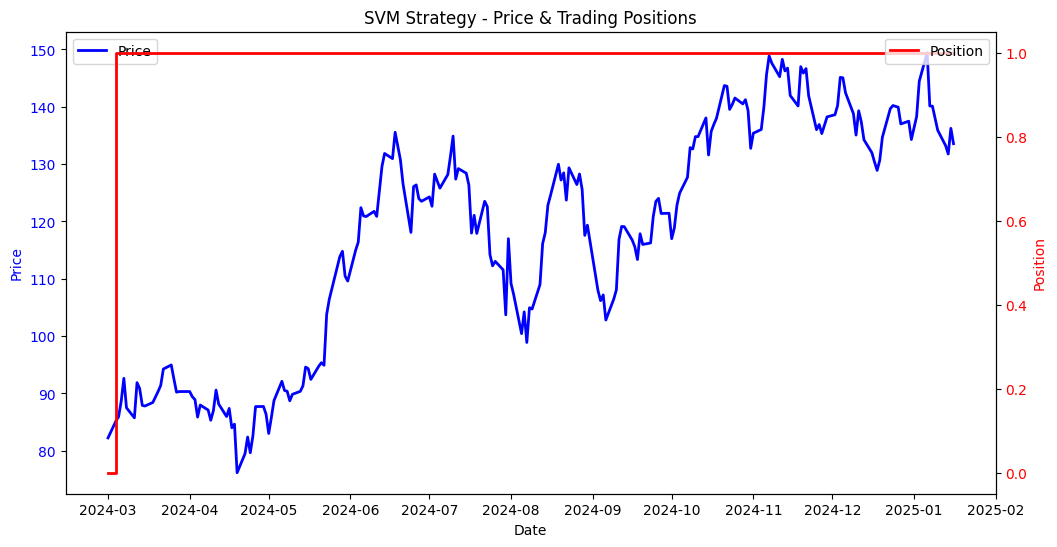

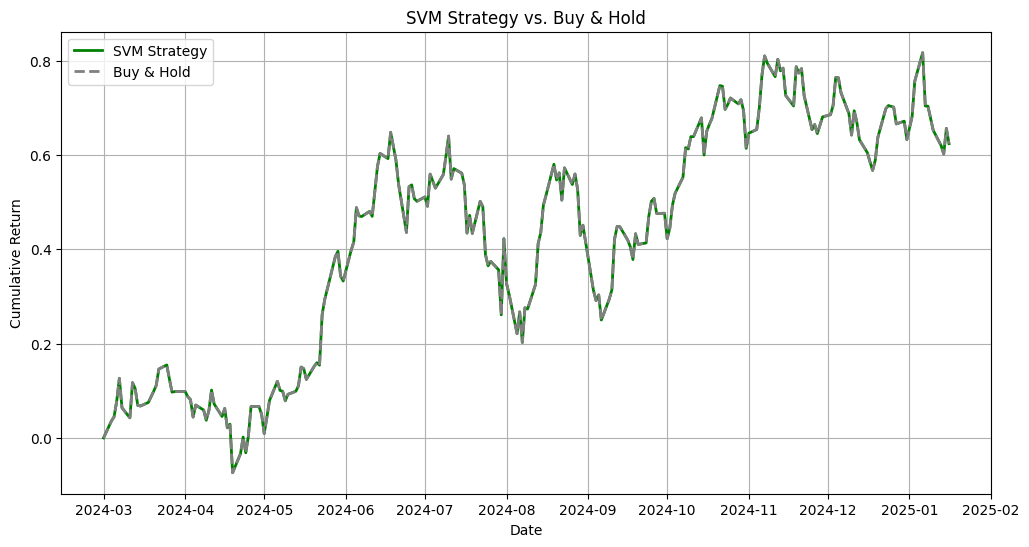

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, mean_absolute_error

# ---------------------------
# Data Preparation and Indicator Calculation
# ---------------------------
def calculate_indicators(df):
    df = df.copy()
    
    # Ensure numeric data types
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Drop rows with NaN in essential columns
    df = df.dropna(subset=['Close'])

    # Relative Strength Index (RSI)
    window = 14
    delta = df['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    # Calculate average gains and losses only when enough data is available
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    df['RSI'] = 100 - (100 / (1 + rs))

    # Stochastic KDJ Indicator
    low_min = df['Low'].rolling(window=14, min_periods=1).min()
    high_max = df['High'].rolling(window=14, min_periods=1).max()
    df['KDJ_K'] = 100 * (df['Close'] - low_min) / (high_max - low_min + 1e-10)
    df['KDJ_D'] = df['KDJ_K'].rolling(window=3, min_periods=1).mean()

    # Moving Averages
    df['SMA_Short'] = df['Close'].rolling(window=7, min_periods=1).mean()
    df['SMA_Long'] = df['Close'].rolling(window=14, min_periods=1).mean()
    df['EMA'] = df['Close'].ewm(span=14, adjust=False).mean()
    df['SMA_EMA_Ratio'] = df['SMA_Short'] / (df['EMA'] + 1e-10)

    # On Balance Volume (OBV)
    if 'Volume' in df.columns:
        df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()
    else:
        df['OBV'] = np.nan

    # Aroon Up & Aroon Down - Fixed calculation
    def aroon_up(x):
        if len(x) == 0 or np.isnan(x).all():
            return np.nan
        return ((len(x) - 1) - np.argmax(x)) / (len(x) - 1) * 100 if len(x) > 1 else np.nan

    def aroon_down(x):
        if len(x) == 0 or np.isnan(x).all():
            return np.nan
        return ((len(x) - 1) - np.argmin(x)) / (len(x) - 1) * 100 if len(x) > 1 else np.nan

    df['Aroon_Up'] = df['High'].rolling(window=14, min_periods=2).apply(aroon_up, raw=True)
    df['Aroon_Down'] = df['Low'].rolling(window=14, min_periods=2).apply(aroon_down, raw=True)

    # Average Directional Index (ADX)
    df['High-Low'] = df['High'] - df['Low']
    df['High-Close'] = np.abs(df['High'] - df['Close'].shift(1))
    df['Low-Close'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TrueRange'] = df[['High-Low', 'High-Close', 'Low-Close']].max(axis=1)
    df['ATR'] = df['TrueRange'].rolling(window=14, min_periods=1).mean()
    df['ADX'] = 100 * (df['ATR'] / (df['Close'] + 1e-10))

    # Chaikin Oscillator
    if 'Volume' in df.columns:
        money_flow_multiplier = ((df['Close'] - df['Low']) - (df['High'] - df['Close'])) / (df['High'] - df['Low'] + 1e-10)
        money_flow_volume = money_flow_multiplier * df['Volume']
        df['Chaikin'] = money_flow_volume.rolling(window=3, min_periods=1).sum()
    else:
        df['Chaikin'] = np.nan

    # Commodity Channel Index (CCI)
    typical_price = (df['High'] + df['Low'] + df['Close']) / 3
    sma_tp = typical_price.rolling(window=14, min_periods=1).mean()
    mean_deviation = (typical_price - sma_tp).abs().rolling(window=14, min_periods=1).mean()
    df['CCI'] = (typical_price - sma_tp) / (0.015 * mean_deviation + 1e-10)

    return df

def prepare_data(filename, close_column='Close'):
    """
    Reads CSV data, sets the date as index, and adds:
      - 'price': the original closing price,
      - 'log_rets': log returns computed as ln(next_day_price / today's price),
      - 'direction': 1 if next day's price is higher, else -1.
    """
    try:
        df = pd.read_csv(filename, index_col=0, parse_dates=True)
        # Make sure we have the required columns
        if close_column not in df.columns:
            raise ValueError(f"Column '{close_column}' not found in the CSV file.")
        
        df = df.dropna(subset=[close_column])
        df['price'] = df[close_column]
        df['log_rets'] = np.log(df[close_column].shift(-1) / df[close_column])
        df['direction'] = np.where(df[close_column].shift(-1) > df[close_column], 1, -1)
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def normalize_data(df, exclude_columns=['price', 'log_rets', 'direction']):
    """Normalize each column individually using MinMaxScaler."""
    if df is None or df.empty:
        return None
    
    scaler = MinMaxScaler()
    df_norm = df.copy()
    for col in df_norm.columns:
        if col in exclude_columns or df_norm[col].isna().all():
            continue
        # Handle NaN values by filling with column mean
        col_values = df_norm[col].fillna(df_norm[col].mean())
        df_norm[col] = scaler.fit_transform(col_values.values.reshape(-1, 1))
    return df_norm

def sequential_train_test_split(df, train_end_date):
    """
    Splits data chronologically. All data up to train_end_date is used for training;
    data after that is used for testing.
    """
    if df is None or df.empty:
        return None, None
    
    try:
        train_end = pd.to_datetime(train_end_date)
        train = df.loc[:train_end].copy()
        test = df.loc[train_end + pd.Timedelta(days=1):].copy()
        
        if train.empty:
            print("Warning: Training set is empty. Check your train_end_date.")
        if test.empty:
            print("Warning: Test set is empty. Check your train_end_date.")
            
        return train, test
    except Exception as e:
        print(f"Error in train-test split: {e}")
        return None, None
    
def tune_feature_count(filename, close_column='Close', train_end_date='2024-02-29', 
                        feature_range=range(3, 16)):
    """
    Tune the optimal number of features by testing different feature counts
    and comparing their performance.
    
    Args:
        filename: CSV file with price data
        close_column: Column name for closing prices
        train_end_date: End date for training data
        feature_range: Range of feature counts to test
        
    Returns:
        DataFrame with performance metrics for each feature count
        and the best feature count
    """
    results = []
    best_return = -float('inf')
    best_feature_count = None
    best_test_data = None
    best_selected_features = None
    
    for num_features in feature_range:
        print(f"\nTesting with {num_features} features...")
        train, test, selected_features = svm_trading_strategy(
            filename=filename,
            close_column=close_column,
            train_end_date=train_end_date,
            num_features=num_features
        )
        
        if test is not None and not test.empty:
            acc, log_ret, simple_ret = evaluate_svm_performance(test)
            
            # Store results
            results.append({
                'num_features': num_features,
                'accuracy': acc,
                'log_return': log_ret,
                'simple_return': simple_ret,
                'selected_features': selected_features
            })
            
            # Track best performing model
            if simple_ret > best_return:
                best_return = simple_ret
                best_feature_count = num_features
                best_test_data = test.copy()
                best_selected_features = selected_features.copy() if selected_features else None
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Print the results table
    print("\nFeature Count Tuning Results:")
    print(results_df[['num_features', 'accuracy', 'log_return', 'simple_return']])
    
    print(f"\nBest feature count: {best_feature_count} with {best_return:.2%} return")
    if best_selected_features:
        print(f"Best features: {best_selected_features}")
        
    return results_df, best_feature_count, best_test_data, best_selected_features

# ---------------------------
# Strategy 2: SVM Trading Strategy with Feature Selection
# ---------------------------
def svm_trading_strategy(filename, close_column='Close', train_end_date='2024-02-29', num_features=7, feature_columns=None):
    """
    Implements an SVM trading strategy with feature selection.
    Methodology:
      - Prepare data (including original price, log returns, and direction).
      - Calculate technical indicators.
      - Normalize features (excluding those needed for return calculation).
      - Split data chronologically into training (≤ train_end_date) and testing (after).
      - Use yesterday's (shifted) normalized indicators to predict tomorrow's direction via SVC.
      - Feature selection is applied on the training data.
      - Predicted signals are shifted by one day to avoid lookahead bias.
      - Returns are computed based on the original (unscaled) price.
    """
    # Prepare data and indicators
    df = prepare_data(filename, close_column)
    if df is None:
        print("Failed to prepare data. Exiting.")
        return None, None, None
    
    # Calculate indicators first, then normalize
    df = calculate_indicators(df)
    df = normalize_data(df)
    
    # Sort by index to ensure chronological order
    df = df.sort_index()

    # Split data chronologically
    train, test = sequential_train_test_split(df, train_end_date)
    if train is None or test is None:
        print("Failed to split data. Exiting.")
        return None, None, None

    # If no specific feature_columns are provided, use all columns except excluded ones
    excluded_cols = ['price', 'log_rets', 'direction', 'Target', 'Predicted_Direction', 'Position', 
                     'Returns', 'StrategyReturns', 'CumulativeReturns', 'BuyHoldReturns']
    
    if feature_columns is None:
        feature_columns = [col for col in df.columns if col not in excluded_cols]
    
    # For SVM, we predict next day's direction using today's features
    # Target is the NEXT day's direction
    train['Target'] = train['direction']
    train = train.dropna(subset=['Target'])
    
    # Handle missing values in features
    X_train = train[feature_columns].copy()
    y_train = train['Target'].copy()
    
    test['Target'] = test['direction']
    test = test.dropna(subset=['Target'])
    X_test = test[feature_columns].copy()
    y_test = test['Target'].copy()

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        index=X_train.index,
        columns=X_train.columns
    )
    
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        index=X_test.index,
        columns=X_test.columns
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imputed),
        index=X_train_imputed.index,
        columns=X_train_imputed.columns
    )
    
    X_test_scaled = pd.DataFrame(
        scaler.transform(X_test_imputed),
        index=X_test_imputed.index,
        columns=X_test_imputed.columns
    )

    # Feature selection using Sequential Feature Selector with an SVC model
    try:
        model = SVC(kernel='poly', degree=2, C=0.3, random_state=42)
        # Limit n_features_to_select to actual number of features if less
        n_select = min(num_features, X_train_scaled.shape[1])
        
        sfs = SequentialFeatureSelector(
            model, 
            n_features_to_select=n_select,
            direction='forward',
            scoring='accuracy',
            cv=5
        )
        
        sfs.fit(X_train_scaled, y_train)
        selected_features = X_train_scaled.columns[sfs.get_support()].tolist()
        print("Selected features:", selected_features)
        
        # Train SVM on selected features
        X_train_selected = sfs.transform(X_train_scaled)
        X_test_selected = sfs.transform(X_test_scaled)
        
        model.fit(X_train_selected, y_train)
        
        # Make predictions
        test_pred = model.predict(X_test_selected)
        
        # Add predictions to test dataframe with proper alignment
        pred_series = pd.Series(test_pred, index=X_test_scaled.index)
        test.loc[pred_series.index, 'Predicted_Direction'] = pred_series
        
        # Shift predictions to avoid lookahead bias
        # When trading on day t, we only know predictions from t-1
        test['Position'] = test['Predicted_Direction'].shift(1).apply(lambda x: 1 if x > 0 else -0.5 if x < 0 else 0).fillna(0)
        
        # Calculate strategy returns
        test['Returns'] = test['price'].pct_change().fillna(0)
        test['StrategyReturns'] = test['Position'] * test['Returns']
        test['CumulativeReturns'] = (1 + test['StrategyReturns']).cumprod() - 1
        test['BuyHoldReturns'] = (1 + test['Returns']).cumprod() - 1
        
        return train, test, selected_features
        
    except Exception as e:
        print(f"Error in SVM strategy implementation: {e}")
        return train, test, None

def plot_svm_strategy(test):
    if test is None or test.empty:
        print("No test data available for plotting.")
        return
    
    # Ensure we have the required columns
    required_cols = ['price', 'Position', 'CumulativeReturns', 'BuyHoldReturns']
    missing_cols = [col for col in required_cols if col not in test.columns]
    if missing_cols:
        print(f"Missing columns for plotting: {missing_cols}")
        return
    
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(test.index, test['price'], label='Price', color='blue', linewidth=2)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    ax2 = ax1.twinx()
    ax2.step(test.index, test['Position'], where='post', label='Position', color='red', linewidth=2)
    ax2.set_ylabel('Position', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.title('SVM Strategy - Price & Trading Positions')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.plot(test.index, test['CumulativeReturns'], label='SVM Strategy', color='green', linewidth=2)
    plt.plot(test.index, test['BuyHoldReturns'], label='Buy & Hold', color='gray', linestyle='--', linewidth=2)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('SVM Strategy vs. Buy & Hold')
    plt.legend()
    plt.grid(True)
    plt.show()

def evaluate_svm_performance(test):
    if test is None or test.empty:
        print("No test data available for evaluation.")
        return None, None, None
    
    # Check if required columns exist
    required_cols = ['Target', 'Predicted_Direction', 'StrategyReturns']
    missing_cols = [col for col in required_cols if col not in test.columns]
    if missing_cols:
        print(f"Missing columns for evaluation: {missing_cols}")
        return None, None, None
    
    # Use only rows where both Target and Predicted_Direction are available
    valid_idx = test.dropna(subset=['Target', 'Predicted_Direction']).index
    if len(valid_idx) == 0:
        print("No valid predictions for accuracy calculation.")
        acc = float('nan')
    else:
        acc = accuracy_score(test.loc[valid_idx, 'Target'], 
                           test.loc[valid_idx, 'Predicted_Direction']) * 100
    
    # Calculate returns metrics
    strategy_returns = test['StrategyReturns'].dropna()
    if len(strategy_returns) == 0:
        print("No valid returns for performance calculation.")
        total_log_ret = float('nan')
        simple_return = float('nan')
    else:
        total_log_ret = np.sum(np.log(1 + strategy_returns))
        simple_return = np.exp(total_log_ret) - 1
    
    print("\nEvaluation Metrics:")
    print(f"Directional Accuracy: {acc:.2f}%")
    print(f"Strategy Log Return: {total_log_ret:.4f}")
    print(f"Strategy Simple Return: {simple_return:.2%}")
    
    return acc, total_log_ret, simple_return

# ---------------------------
# Sample Usage
# ---------------------------
if __name__ == "__main__":
    filename = 'NVDA.csv'
    close_column = 'Close'
    train_end_date = '2024-02-29'
    
    # Tune the feature count
    results_df, best_feature_count, best_test_data, best_features = tune_feature_count(
        filename=filename,
        close_column=close_column,
        train_end_date=train_end_date,
        feature_range=range(3, 16)  # Test from 3 to 15 features
    )
    
    # Plot the results from the best model
    if best_test_data is not None:
        print("\nPlotting results for the best model...")
        plot_svm_strategy(best_test_data)